# Detection model

## 순서
1. [Import Module](#Impor-Module)
2. [데이터 확인](#데이터-확인)
3. [데이터 전처리](#데이터-전처리)
4. [model 만들기](#model-만들기)

## Import Module

In [1]:
import numpy as np 
import pandas as pd

# Deeplearning
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

# Data load
import os
import cv2
import glob
import random
from torch.utils.data import TensorDataset, Dataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
from torchvision import datasets, transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## 데이터 확인

In [3]:
df_meta=pd.read_csv("/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv",index_col=0)
df_meta.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
print(df_meta["Label"].astype('category').unique)

<bound method Series.unique of 0         Normal
1         Normal
2         Normal
3         Normal
4         Normal
          ...   
5928    Pnemonia
5929    Pnemonia
5930    Pnemonia
5931    Pnemonia
5932    Pnemonia
Name: Label, Length: 5910, dtype: category
Categories (2, object): ['Normal', 'Pnemonia']>


데이터의 클래스가 'Normal', 'Pnemonia'임을 알 수 있음 

----------

### 이미지 별 채널수 확인

In [5]:
path = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/1-s2.0-S1684118220300682-main.pdf-002-a1.png'
train = cv2.imread(path)
train.shape

(362, 439, 3)

images=glob.glob("../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/*")
print(len(images),'\n')

temp = []
for i in range(len(images)):
    image = cv2.imread(images[i])
    temp.append(image.shape[2])
    
temp = pd.DataFrame(temp)
print(temp.value_counts())

### 데이터 분포 확인

In [6]:
df_meta[df_meta["Dataset_type"]=="TRAIN"]["Label"].value_counts()

Pnemonia    3944
Normal      1342
Name: Label, dtype: int64

<AxesSubplot:>

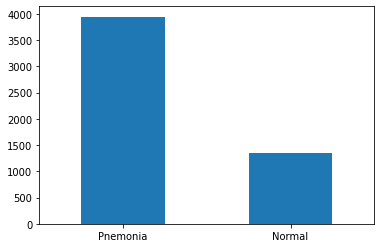

In [7]:
df_meta[df_meta["Dataset_type"]=="TRAIN"]["Label"].value_counts().plot.bar(rot=0)

클래스의 분포가 위와 같음을 알 수 있음

AxesSubplot(0.125,0.125;0.775x0.755)


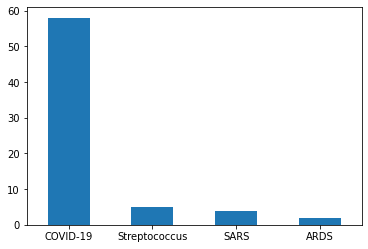

In [8]:
df_pne = df_meta[df_meta["Label"]=='Pnemonia']

print(df_pne["Label_2_Virus_category"].value_counts().plot.bar(rot=0))

AxesSubplot(0.125,0.125;0.775x0.755)


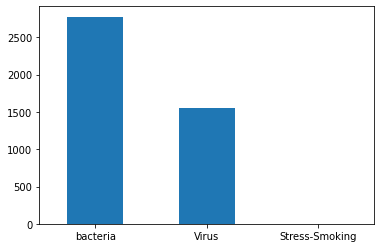

In [9]:
print(df_pne["Label_1_Virus_category"].value_counts().plot.bar(rot=0))

### 클래스별 이미지 확인하기

In [10]:
path = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'

정상 이미지 출력

normal
이미지 크기:  (1013, 1528, 3)


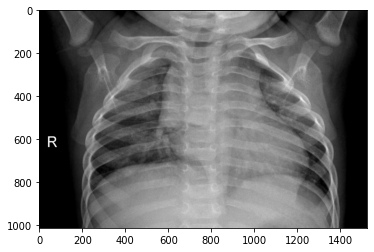

In [11]:
normal = df_meta[df_meta["Label"]=="Normal"]
image = cv2.imread(path + normal.iloc[0]['X_ray_image_name'])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) 
plt.imshow(image)
print('normal')
print('이미지 크기: ',image.shape)

--------------------
폐렴(Pnemonia(corona)) 이미지 출력

pnemonia
이미지 크기:  (1752, 1736, 3)


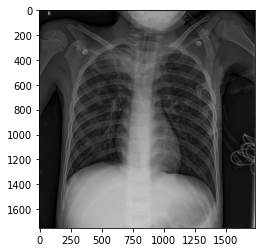

In [12]:
pnemonia=df_meta[df_meta["Label"]=="Pnemonia"]
image = cv2.imread(path + pnemonia.iloc[0]['X_ray_image_name'])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)
print('pnemonia')
print('이미지 크기: ',image.shape)

-----------------------
### 이미지 파일 확인

In [13]:
images=glob.glob("../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/*")
images=pd.Series(images)
print("train 이미지 파일 개수: ",len(images))

train 이미지 파일 개수:  5309


In [14]:
image_jpg=glob.glob("../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/*.jpg")
image_jpg=pd.Series(image_jpg)
print("jpg 파일 개수: ",len(image_jpg),'\n')

image_jpeg=glob.glob("../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/*.jpeg")
image_jpeg=pd.Series(image_jpeg)
print("jpeg 파일 개수: ",len(image_jpeg),'\n')

image_png=glob.glob("../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/*.png")
image_png=pd.Series(image_png)
print("png 파일 개수: ", len(image_png))

jpg 파일 개수:  37 

jpeg 파일 개수:  5264 

png 파일 개수:  8


In [15]:
# image파일의 종류는 png와 jpeg, jpg인 것을 확인
len(images)==len(image_png)+len(image_jpeg)+len(image_jpg)

True

> 데이터를 확인해보니 이미지는 3개의 형식(jpg, jpeg, png)으로 저장되어있고 이미지들은 모두 다른 shape를 갖고 있었다.  
이는 데이터 전처리과정에서 이미지의 크기를 모두 통일시키는 방향으로 문제를 해결해야 할 것 같다.  
또한 label1과 2를 사용해 데이터를 분류해보았을때 코로나 환자의 이미지는 총 train data의 1%밖에 안되는 것을 확인할 수 있었다.  
그래서 우리는 폐렴을 detect하는 model을 만드는 것으로 프로젝트 방향을 바꾸기로 하였다.

## 데이터 전처리
---
당장은 아래와 같은 코드를 만들었지만 [링크](https://greeksharifa.github.io/pytorch/2018/11/10/pytorch-usage-03-How-to-Use-PyTorch/)를 읽어보고 다시 코드를 만들어 볼 것!

### transforms

`>` Resize를 통해 train image data의 size를 맞춰주고 Nomarlize를 통해 픽셀값을 0 ~ 1사이로 맞춰 준다.

---

`#`  [Batch Nomarlization을 하는 이유](https://sonsnotation.blogspot.com/2020/11/8-normalization.html)

In [16]:
input_size = 224
transform = transforms.Compose([
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0,0,0),std=(1,1,1)) #아마 표준화..?
])

transform

Compose(
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0, 0, 0), std=(1, 1, 1))
)

### datasets

`>` 앞서 만든 transform을 사용하여 train data를 가공한다. 가공된 데이터들을 모아 datasets을 만든다.

In [17]:
path = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset'

In [18]:
images_dataset = datasets.ImageFolder(root = path, transform = transform) 

In [19]:
len(images_dataset)

5933

### DataLoader

`>` dataset에 있는 데이터들을 사용해 dataloader를 만드는데 이때 배치사이즈와 데이터를 섞을지 등을 결정한다.

In [20]:
dataloader = DataLoader(images_dataset, batch_size= 50, shuffle=True, num_workers=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## model 만들기

## ResNet50을 사용

In [21]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # L1 ImgIn shape=(?, 224, 224, 3)
        #    Conv     -> (?, 224, 224, 32)
        #    Pool     -> (?, 112, 112, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # L2 ImgIn shape=(?, 112, 112, 32)
        #    Conv      ->(?, 112, 112, 64)
        #    Pool      ->(?, 56, 56, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        # L3 ImgIn shape=(?, 56, 56, 64)
        #    Conv      ->(?, 56, 56, 128)
        #    Pool      ->(?, 28, 28, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = torch.nn.Linear(28 * 28 * 128, 10, bias=True)
        
        torch.nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [22]:
model = CNN().to(device)

In [23]:
learning_rate = 0.001
epochs = 100
batch_size = 10

In [24]:
criterion = torch.nn.CrossEntropyLoss().to(device) # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
for j, [image,label] in enumerate(dataloader):
    print(image.shape)
    break

torch.Size([50, 3, 224, 224])


In [26]:
loss_arr = []
for i in range(epochs):
    for j, [image,label] in enumerate(dataloader):
        x = image.to(device)
        y = label.to(device)
        
        optimizer.zero_grad()
        
        output = model.forward(x)
        
        loss = criterion(output, y)
        loss.backward()
        
        optimizer.step()
        
        if j % 10 == 0 :
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3312, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4640, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4413, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3669, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3693, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3286, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2964, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2869, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1954, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3802, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4247, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3707, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4823, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4201, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3310, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2448, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3653, device='cuda:0', grad_fn=